# Approach 2: Multi-Label Contrastive Learning for Aerial Image Classification

This notebook implements a contrastive learning approach for multi-label aerial image classification.

## Key Innovations:
- **Multi-Label Supervised Contrastive Loss**: Learns representations where images with shared labels are pulled together
- **Hybrid Training**: Combines BCE classification loss with contrastive loss
- **Label-Aware Similarity**: Uses Jaccard index to define soft positive/negative pairs
- **Improved Rare Class Performance**: Contrastive learning helps minority classes

## Expected Improvements:
- Better macro F1 score (especially for rare classes like chaparral)
- More discriminative features between visually similar classes
- Implicit label correlation modeling

## Dataset Preprocessing:
- **Mobile home class excluded**: Only 2 samples total (0 in test set), which unfairly impacts macro F1
- Working with 16 classes instead of 17

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install torch torchvision transformers datasets pillow matplotlib scikit-learn tqdm timm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from datasets import load_dataset
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [3]:
# check memory ram via torch
def check_gpu_memory_usage():
    if torch.cuda.is_available():
        # 2. Get the current memory allocated (used by tensors)
        allocated = torch.cuda.memory_allocated() / 1024**2 # Convert to MB

        # 3. Get the total memory reserved by the PyTorch cacher
        reserved = torch.cuda.memory_reserved() / 1024**2

        # 4. Get the total capacity of the GPU
        total_capacity = torch.cuda.get_device_properties(0).total_memory / 1024**2

        print(f"Allocated Memory: {allocated:.2f} MB")
        print(f"Reserved Memory:  {reserved:.2f} MB")
        print(f"Total Capacity:   {total_capacity:.2f} MB")

In [4]:
check_gpu_memory_usage()

Allocated Memory: 0.00 MB
Reserved Memory:  0.00 MB
Total Capacity:   40506.81 MB


## 2. Load Dataset (Same as Baseline)

In [5]:
# Load dataset from HuggingFace
print("Loading AID_MultiLabel dataset...")
dataset = load_dataset("jonathan-roberts1/AID_MultiLabel")

print(f"\nDataset Info:")
print(f"Number of samples: {dataset['train'].num_rows}")
print(f"Features: {dataset['train'].features}")

# Extract class names and filter out mobile home (index 9)
all_class_names = dataset['train'].features['label'].feature.names
MOBILE_HOME_IDX = 9

# Filter out mobile home class (only 2 samples total, 0 in test set)
class_names = [name for i, name in enumerate(all_class_names) if i != MOBILE_HOME_IDX]
num_classes = len(class_names)  # 16 classes instead of 17

print(f"\nFiltered out '{all_class_names[MOBILE_HOME_IDX]}' class (insufficient samples)")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Loading AID_MultiLabel dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-ee58cb5d786e11(…):   0%|          | 0.00/278M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]


Dataset Info:
Number of samples: 3000
Features: {'image': Image(mode=None, decode=True), 'label': List(ClassLabel(names=['airplane', 'bare soil', 'buildings', 'cars', 'chaparral', 'court', 'dock', 'field', 'grass', 'mobile home', 'pavement', 'sand', 'sea', 'ship', 'tanks', 'trees', 'water']))}

Filtered out 'mobile home' class (insufficient samples)
Number of classes: 16
Class names: ['airplane', 'bare soil', 'buildings', 'cars', 'chaparral', 'court', 'dock', 'field', 'grass', 'pavement', 'sand', 'sea', 'ship', 'tanks', 'trees', 'water']


In [6]:
# size of each label
# dataset to df
import pandas as pd
df = pd.DataFrame(dataset['train'])
df.head()

,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[0, 1, 2, 3, 8, 10]"
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[0, 1, 2, 3, 8, 10, 15]"
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[0, 2, 3, 8, 10]"
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[0, 1, 2, 3, 8, 10]"
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[0, 1, 2, 3, 8, 10]"


In [7]:
# go through labels and increment the count
all_labels = df['label'].explode()

# Count occurrences of each label index
label_counts = all_labels.value_counts().sort_index()

# Create frequency distribution excluding mobile home (index 9)
# Map to the NEW class indices (after removing mobile home)
distribution_df = pd.DataFrame({
    'Class Name': class_names,
    'Frequency': [label_counts.get(i if i < MOBILE_HOME_IDX else i + 1, 0) for i in range(len(class_names))]
})

# Display sorted by most frequent
print(distribution_df.sort_values(by='Frequency', ascending=False))

   Class Name  Frequency
14      trees       2406
9    pavement       2328
8       grass       2295
2   buildings       2161
3        cars       2026
1   bare soil       1475
15      water        852
5       court        344
12       ship        284
6        dock        271
10       sand        259
11        sea        221
7       field        214
4   chaparral        112
13      tanks        108
0    airplane         99


In [8]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transformations defined.")

Transformations defined.


In [9]:
# Custom Dataset class
class AIDMultiLabelDataset(Dataset):
    def __init__(self, images, labels, num_classes, transform=None):
        self.images = images
        self.labels = labels
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Labels are already filtered and adjusted in the data split step
        label_vector = torch.zeros(self.num_classes, dtype=torch.float32)
        if self.labels[idx]:
            label_vector[self.labels[idx]] = 1.0

        return image, label_vector

print("Custom Dataset class defined.")

Custom Dataset class defined.


In [10]:
# Split dataset: 70% train, 15% validation, 15% test
images = list(dataset['train']['image'])
labels = list(dataset['train']['label'])

X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

# Filter out mobile home (index 9) from all label lists and adjust indices
def filter_and_adjust_labels(label_lists, exclude_idx=9):
    """Remove exclude_idx and shift down indices > exclude_idx"""
    filtered = []
    for label_list in label_lists:
        # Remove the excluded class
        filtered_labels = [l for l in label_list if l != exclude_idx]
        # Adjust indices (shift down if > exclude_idx)
        adjusted_labels = [l if l < exclude_idx else l - 1 for l in filtered_labels]
        filtered.append(adjusted_labels)
    return filtered

y_train = filter_and_adjust_labels(y_train, exclude_idx=MOBILE_HOME_IDX)
y_val = filter_and_adjust_labels(y_val, exclude_idx=MOBILE_HOME_IDX)
y_test = filter_and_adjust_labels(y_test, exclude_idx=MOBILE_HOME_IDX)

print(f"Dataset split:")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(images)*100:.1f}%)")
print(f"  Validation samples: {len(X_val)} ({len(X_val)/len(images)*100:.1f}%)")
print(f"  Test samples: {len(X_test)} ({len(X_test)/len(images)*100:.1f}%)")
print(f"  Labels filtered to exclude mobile home (index {MOBILE_HOME_IDX})")

Dataset split:
  Training samples: 2100 (70.0%)
  Validation samples: 450 (15.0%)
  Test samples: 450 (15.0%)
  Labels filtered to exclude mobile home (index 9)


In [11]:
# Create dataset objects
train_dataset = AIDMultiLabelDataset(X_train, y_train, num_classes, transform=train_transform)
val_dataset = AIDMultiLabelDataset(X_val, y_val, num_classes, transform=val_transform)
test_dataset = AIDMultiLabelDataset(X_test, y_test, num_classes, transform=val_transform)

print("Dataset objects created successfully.")

Dataset objects created successfully.


In [12]:
# Weighted sampling for class imbalance
BATCH_SIZE = 64

def get_sample_weights(labels_list_of_lists, num_classes):
    labels_multihot = np.zeros((len(labels_list_of_lists), num_classes), dtype=np.float32)
    for i, label_indices in enumerate(labels_list_of_lists):
        if label_indices:
            labels_multihot[i, label_indices] = 1.0

    pos_counts = labels_multihot.sum(axis=0)
    label_weights = 1.0 / (pos_counts + 1e-6)

    sample_weights = []
    for label_indices_for_image in labels_list_of_lists:
        if label_indices_for_image:
            weight = np.mean([label_weights[idx] for idx in label_indices_for_image])
        else:
            weight = 1.0
        sample_weights.append(weight)

    return torch.DoubleTensor(sample_weights)

sample_weights = get_sample_weights(y_train, num_classes)
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Data loaders created with weighted sampling.")

Data loaders created with weighted sampling.


## 3. Multi-Label Contrastive Loss Implementation

In [13]:
class MultiLabelSupConLoss(nn.Module):
    """
    Supervised Contrastive Loss adapted for Multi-Label Classification.

    Key idea: Images sharing labels should have similar representations.
    - Positive pairs: Images sharing at least one label
    - Negative pairs: Images sharing no labels
    - Soft weighting: Use Jaccard similarity for partial overlap
    """
    def __init__(self, temperature=0.07, base_temperature=0.07, use_jaccard=True):
        super(MultiLabelSupConLoss, self).__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature
        self.use_jaccard = use_jaccard

    def forward(self, features, labels):
        """
        Args:
            features: [batch_size, feature_dim] - normalized feature vectors
            labels: [batch_size, num_classes] - multi-hot label vectors
        """
        device = features.device
        batch_size = features.shape[0]

        # Normalize features
        features = F.normalize(features, dim=1)

        # Compute similarity matrix
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )

        # For numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # Compute label similarity (Jaccard index or binary overlap)
        if self.use_jaccard:
            # Jaccard similarity: |A ∩ B| / |A ∪ B|
            intersection = torch.matmul(labels, labels.T)
            union = labels.sum(1).unsqueeze(1) + labels.sum(1).unsqueeze(0) - intersection
            label_similarity = intersection / (union + 1e-8)
        else:
            # Binary: 1 if sharing at least one label, 0 otherwise
            labels_overlap = torch.matmul(labels, labels.T)
            label_similarity = (labels_overlap > 0).float()

        # Mask for valid pairs (exclude diagonal)
        logits_mask = torch.ones_like(label_similarity) - torch.eye(batch_size, device=device)

        # Mask for positive pairs (weighted by label similarity)
        mask = label_similarity * logits_mask

        # Compute log probabilities
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-8)

        # Weighted mean of log-likelihood over positive pairs
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)

        # Loss
        loss = -(self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.mean()

        return loss

print("Multi-Label Supervised Contrastive Loss defined.")

Multi-Label Supervised Contrastive Loss defined.


## 4. Model Architecture with Contrastive Learning

In [14]:
class MultiLabelContrastiveModel(nn.Module):
    """
    Multi-Label Classification Model with Contrastive Learning.

    Architecture:
    - Backbone: EfficientNet-B4 (pre-trained on ImageNet)
    - Projection Head: For contrastive learning (256-dim)
    - Classification Head: For multi-label prediction (num_classes)
    """
    def __init__(self, num_classes, model_name='efficientnet_b4', pretrained=True, dropout=0.25):
        super(MultiLabelContrastiveModel, self).__init__()

        dropout = 0.0

        # Backbone: EfficientNet-B4
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
            global_pool=''   # Remove global pooling
        )

        num_features = self.backbone.num_features  # 1792 for EfficientNet-B4

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.Linear(512, 256)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            #nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

        print(f"Model initialized:")
        print(f"  Backbone: {model_name} (pretrained={pretrained})")
        print(f"  Feature dimension: {num_features}")
        print(f"  Projection dimension: 256")
        print(f"  Output classes: {num_classes}")
        print(f"  Dropout: {dropout}")

    def forward(self, x, return_features=False, return_projection=False):
        # Extract features from backbone
        features = self.backbone(x)
        features = self.global_pool(features)
        features = features.flatten(1)

        if return_projection:
            # Return projected features for contrastive learning
            projected = self.projection_head(features)
            return projected

        if return_features:
            # Return both logits and features
            logits = self.classifier(features)
            return logits, features

        # Default: return classification logits
        logits = self.classifier(features)
        return logits

print("Multi-Label Contrastive Model class defined.")

Multi-Label Contrastive Model class defined.


In [15]:
# Initialize model
MODEL_BACKBONE = 'efficientnet_b4'
#DROPOUT_RATE = 0.25 -> removed since no overfitting is observed in training

model = MultiLabelContrastiveModel(
    num_classes=num_classes,
    model_name=MODEL_BACKBONE,
    pretrained=True
)

model = model.to(device)

print(f"\nModel moved to {device}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model initialized:
  Backbone: efficientnet_b4 (pretrained=True)
  Feature dimension: 1792
  Projection dimension: 256
  Output classes: 16
  Dropout: 0.0

Model moved to cuda
Total parameters: 19,524,184
Trainable parameters: 19,524,184


## 5. Loss Functions and Optimizer

In [16]:
# Loss functions
criterion_bce = nn.BCEWithLogitsLoss()
criterion_contrastive = MultiLabelSupConLoss(
    temperature=0.07,
    base_temperature=0.07,
    use_jaccard=True  # Use Jaccard similarity for soft weighting
)

# Contrastive loss weight
LAMBDA_CONTRASTIVE = 0.05  # Balance between BCE and contrastive loss

print("Loss functions:")
print(f"  1. BCEWithLogitsLoss (for classification)")
print(f"  2. MultiLabelSupConLoss (for contrastive learning)")
print(f"  Contrastive weight (λ): {LAMBDA_CONTRASTIVE}")

Loss functions:
  1. BCEWithLogitsLoss (for classification)
  2. MultiLabelSupConLoss (for contrastive learning)
  Contrastive weight (λ): 0.05


In [17]:
# Optimizer and Learning Rate Scheduler
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

print(f"\nOptimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"\nScheduler: ReduceLROnPlateau")
print(f"  Factor: 0.5")
print(f"  Patience: 3 epochs")


Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 0.0001

Scheduler: ReduceLROnPlateau
  Factor: 0.5
  Patience: 3 epochs


## 6. Training and Evaluation Functions

In [18]:
def train_one_epoch_contrastive(model, dataloader, criterion_bce, criterion_contrastive,
                                optimizer, device, lambda_con=0.5):
    """
    Train model for one epoch with contrastive learning.
    """
    model.train()
    running_loss = 0.0
    running_loss_bce = 0.0
    running_loss_con = 0.0

    progress_bar = tqdm(dataloader, desc='Training')

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass: get classification logits
        logits = model(images)

        # Forward pass: get projected features for contrastive learning
        projected_features = model(images, return_projection=True)

        # Compute losses
        loss_bce = criterion_bce(logits, labels)
        loss_con = criterion_contrastive(projected_features, labels)

        # Combined loss
        loss = loss_bce + lambda_con * loss_con

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_bce += loss_bce.item()
        running_loss_con += loss_con.item()

        progress_bar.set_postfix({
            'loss': loss.item(),
            'bce': loss_bce.item(),
            'con': loss_con.item()
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_loss_bce = running_loss_bce / len(dataloader)
    epoch_loss_con = running_loss_con / len(dataloader)

    return epoch_loss, epoch_loss_bce, epoch_loss_con

In [19]:
def evaluate(model, dataloader, criterion, device, threshold=0.5):
    """
    Evaluate model on validation/test set.
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Get probabilities and predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return epoch_loss, all_preds, all_labels, all_probs

In [27]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss

def calculate_metrics(y_true, y_pred, class_names):
    """
    Calculate comprehensive metrics for multi-label classification.
    """
    # Overall metrics
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    micro_precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    micro_recall = recall_score(y_true, y_pred, average='micro', zero_division=0)

    hamming = hamming_loss(y_true, y_pred)
    subset_acc = np.mean(np.all(y_true == y_pred, axis=1))

    # Per-class metrics
    per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    per_class_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    per_class_recall = recall_score(y_true, y_pred, average=None, zero_division=0)

    metrics = {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'micro_precision': micro_precision,
        'macro_precision': macro_precision,
        'micro_recall': micro_recall,
        'macro_recall': macro_recall,
        'hamming_loss': hamming,
        'subset_accuracy': subset_acc,
        'per_class_f1': per_class_f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall
    }

    return metrics

def print_metrics(metrics):
    """
    Print metrics in a formatted table.
    """
    print("=" * 60)
    print("EVALUATION METRICS")
    print("=" * 60)
    print()
    print("Overall Performance:")
    print(f"  Micro F1:      {metrics['micro_f1']:.4f}")
    print(f"  Macro F1:      {metrics['macro_f1']:.4f}")
    print(f"  Weighted F1:   {metrics['weighted_f1']:.4f}")
    print()
    print(f"  Micro Precision: {metrics['micro_precision']:.4f}")
    print(f"  Macro Precision: {metrics['macro_precision']:.4f}")
    print()
    print(f"  Micro Recall:    {metrics['micro_recall']:.4f}")
    print(f"  Macro Recall:    {metrics['macro_recall']:.4f}")
    print()
    print(f"  Hamming Loss:    {metrics['hamming_loss']:.4f}")
    print(f"  Subset Accuracy: {metrics['subset_accuracy']:.4f}")
    print("=" * 60)
    print()

print("Metrics calculation and printing functions defined.")

Metrics calculation and printing functions defined.


## 7. Training Loop with Contrastive Learning

In [21]:
# Training configuration
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 15

# For tracking
history = {
    'train_loss': [],
    'train_loss_bce': [],
    'train_loss_con': [],
    'val_loss': [],
    'val_micro_f1': [],
    'val_macro_f1': [],
}

best_val_f1 = 0.0
best_model_path = 'best_model_contrastive.pth'
epochs_no_improve = 0

print(f"Starting training for {NUM_EPOCHS} epochs with contrastive learning...")
print(f"Contrastive weight (λ): {LAMBDA_CONTRASTIVE}")
print(f"Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"Best model will be saved to: {best_model_path}\n")

Starting training for 50 epochs with contrastive learning...
Contrastive weight (λ): 0.05
Early stopping patience: 15
Best model will be saved to: best_model_contrastive.pth



In [22]:
# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train with contrastive learning
    train_loss, train_loss_bce, train_loss_con = train_one_epoch_contrastive(
        model, train_loader, criterion_bce, criterion_contrastive,
        optimizer, device, lambda_con=LAMBDA_CONTRASTIVE
    )

    # Validate
    val_loss, val_preds, val_labels, val_probs = evaluate(
        model, val_loader, criterion_bce, device, threshold=0.5
    )

    # Calculate metrics
    val_metrics = calculate_metrics(val_labels, val_preds, class_names)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_loss_bce'].append(train_loss_bce)
    history['train_loss_con'].append(train_loss_con)
    history['val_loss'].append(val_loss)
    history['val_micro_f1'].append(val_metrics['micro_f1'])
    history['val_macro_f1'].append(val_metrics['macro_f1'])

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} (BCE: {train_loss_bce:.4f}, Con: {train_loss_con:.4f})")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Micro F1: {val_metrics['micro_f1']:.4f}")
    print(f"  Val Macro F1: {val_metrics['macro_f1']:.4f}")

    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"  Current LR: {current_lr:.6f}")

    # Save best model
    if val_metrics['macro_f1'] > best_val_f1:
        best_val_f1 = val_metrics['macro_f1']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': best_val_f1,
            'metrics': val_metrics
        }, best_model_path)
        print(f"  ✓ New best model saved! (Macro F1: {best_val_f1:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")

    # Early stopping
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best validation Macro F1: {best_val_f1:.4f}")
print(f"{'='*60}")


Epoch 1/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]



Epoch 1 Summary:
  Train Loss: 0.4681 (BCE: 0.3320, Con: 2.7209)
  Val Loss:   0.2588
  Val Micro F1: 0.8372
  Val Macro F1: 0.5087
  Current LR: 0.001000
  ✓ New best model saved! (Macro F1: 0.5087)

Epoch 2/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]



Epoch 2 Summary:
  Train Loss: 0.3061 (BCE: 0.1752, Con: 2.6191)
  Val Loss:   0.2001
  Val Micro F1: 0.8714
  Val Macro F1: 0.7517
  Current LR: 0.001000
  ✓ New best model saved! (Macro F1: 0.7517)

Epoch 3/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]



Epoch 3 Summary:
  Train Loss: 0.2552 (BCE: 0.1297, Con: 2.5096)
  Val Loss:   0.1843
  Val Micro F1: 0.8865
  Val Macro F1: 0.7916
  Current LR: 0.001000
  ✓ New best model saved! (Macro F1: 0.7916)

Epoch 4/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]



Epoch 4 Summary:
  Train Loss: 0.2418 (BCE: 0.1147, Con: 2.5431)
  Val Loss:   0.1784
  Val Micro F1: 0.8935
  Val Macro F1: 0.7811
  Current LR: 0.001000
  No improvement for 1 epoch(s)

Epoch 5/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]



Epoch 5 Summary:
  Train Loss: 0.2346 (BCE: 0.1043, Con: 2.6058)
  Val Loss:   0.1563
  Val Micro F1: 0.9025
  Val Macro F1: 0.8173
  Current LR: 0.001000
  ✓ New best model saved! (Macro F1: 0.8173)

Epoch 6/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]



Epoch 6 Summary:
  Train Loss: 0.2261 (BCE: 0.0963, Con: 2.5951)
  Val Loss:   0.1583
  Val Micro F1: 0.9087
  Val Macro F1: 0.7942
  Current LR: 0.001000
  No improvement for 1 epoch(s)

Epoch 7/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]



Epoch 7 Summary:
  Train Loss: 0.2198 (BCE: 0.0907, Con: 2.5824)
  Val Loss:   0.1653
  Val Micro F1: 0.9044
  Val Macro F1: 0.8067
  Current LR: 0.001000
  No improvement for 2 epoch(s)

Epoch 8/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]



Epoch 8 Summary:
  Train Loss: 0.2189 (BCE: 0.0897, Con: 2.5850)
  Val Loss:   0.1668
  Val Micro F1: 0.9048
  Val Macro F1: 0.8034
  Current LR: 0.001000
  No improvement for 3 epoch(s)

Epoch 9/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]



Epoch 9 Summary:
  Train Loss: 0.2071 (BCE: 0.0810, Con: 2.5223)
  Val Loss:   0.1645
  Val Micro F1: 0.8934
  Val Macro F1: 0.7963
  Current LR: 0.000500
  No improvement for 4 epoch(s)

Epoch 10/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]



Epoch 10 Summary:
  Train Loss: 0.2051 (BCE: 0.0745, Con: 2.6119)
  Val Loss:   0.1525
  Val Micro F1: 0.9066
  Val Macro F1: 0.8205
  Current LR: 0.000500
  ✓ New best model saved! (Macro F1: 0.8205)

Epoch 11/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]



Epoch 11 Summary:
  Train Loss: 0.1895 (BCE: 0.0615, Con: 2.5600)
  Val Loss:   0.1525
  Val Micro F1: 0.9055
  Val Macro F1: 0.8359
  Current LR: 0.000500
  ✓ New best model saved! (Macro F1: 0.8359)

Epoch 12/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]



Epoch 12 Summary:
  Train Loss: 0.1864 (BCE: 0.0599, Con: 2.5292)
  Val Loss:   0.1521
  Val Micro F1: 0.9091
  Val Macro F1: 0.8249
  Current LR: 0.000500
  No improvement for 1 epoch(s)

Epoch 13/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]



Epoch 13 Summary:
  Train Loss: 0.1801 (BCE: 0.0553, Con: 2.4970)
  Val Loss:   0.1625
  Val Micro F1: 0.9036
  Val Macro F1: 0.8155
  Current LR: 0.000500
  No improvement for 2 epoch(s)

Epoch 14/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]



Epoch 14 Summary:
  Train Loss: 0.1829 (BCE: 0.0520, Con: 2.6168)
  Val Loss:   0.1795
  Val Micro F1: 0.9057
  Val Macro F1: 0.8250
  Current LR: 0.000500
  No improvement for 3 epoch(s)

Epoch 15/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]



Epoch 15 Summary:
  Train Loss: 0.1696 (BCE: 0.0460, Con: 2.4720)
  Val Loss:   0.1731
  Val Micro F1: 0.9067
  Val Macro F1: 0.8274
  Current LR: 0.000500
  No improvement for 4 epoch(s)

Epoch 16/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]



Epoch 16 Summary:
  Train Loss: 0.1703 (BCE: 0.0469, Con: 2.4672)
  Val Loss:   0.1710
  Val Micro F1: 0.9059
  Val Macro F1: 0.8268
  Current LR: 0.000250
  No improvement for 5 epoch(s)

Epoch 17/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]



Epoch 17 Summary:
  Train Loss: 0.1688 (BCE: 0.0403, Con: 2.5707)
  Val Loss:   0.1671
  Val Micro F1: 0.9101
  Val Macro F1: 0.8292
  Current LR: 0.000250
  No improvement for 6 epoch(s)

Epoch 18/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]



Epoch 18 Summary:
  Train Loss: 0.1578 (BCE: 0.0323, Con: 2.5096)
  Val Loss:   0.1990
  Val Micro F1: 0.9051
  Val Macro F1: 0.8341
  Current LR: 0.000250
  No improvement for 7 epoch(s)

Epoch 19/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]



Epoch 19 Summary:
  Train Loss: 0.1581 (BCE: 0.0326, Con: 2.5094)
  Val Loss:   0.1927
  Val Micro F1: 0.9097
  Val Macro F1: 0.8288
  Current LR: 0.000250
  No improvement for 8 epoch(s)

Epoch 20/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]



Epoch 20 Summary:
  Train Loss: 0.1534 (BCE: 0.0300, Con: 2.4688)
  Val Loss:   0.1858
  Val Micro F1: 0.9123
  Val Macro F1: 0.8419
  Current LR: 0.000125
  ✓ New best model saved! (Macro F1: 0.8419)

Epoch 21/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]



Epoch 21 Summary:
  Train Loss: 0.1530 (BCE: 0.0241, Con: 2.5779)
  Val Loss:   0.1933
  Val Micro F1: 0.9121
  Val Macro F1: 0.8353
  Current LR: 0.000125
  No improvement for 1 epoch(s)

Epoch 22/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]



Epoch 22 Summary:
  Train Loss: 0.1423 (BCE: 0.0211, Con: 2.4239)
  Val Loss:   0.2219
  Val Micro F1: 0.9098
  Val Macro F1: 0.8337
  Current LR: 0.000125
  No improvement for 2 epoch(s)

Epoch 23/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]



Epoch 23 Summary:
  Train Loss: 0.1403 (BCE: 0.0162, Con: 2.4812)
  Val Loss:   0.2341
  Val Micro F1: 0.9070
  Val Macro F1: 0.8230
  Current LR: 0.000125
  No improvement for 3 epoch(s)

Epoch 24/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]



Epoch 24 Summary:
  Train Loss: 0.1406 (BCE: 0.0182, Con: 2.4472)
  Val Loss:   0.2285
  Val Micro F1: 0.9131
  Val Macro F1: 0.8342
  Current LR: 0.000063
  No improvement for 4 epoch(s)

Epoch 25/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]



Epoch 25 Summary:
  Train Loss: 0.1418 (BCE: 0.0157, Con: 2.5216)
  Val Loss:   0.2300
  Val Micro F1: 0.9119
  Val Macro F1: 0.8302
  Current LR: 0.000063
  No improvement for 5 epoch(s)

Epoch 26/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]



Epoch 26 Summary:
  Train Loss: 0.1393 (BCE: 0.0142, Con: 2.5014)
  Val Loss:   0.2302
  Val Micro F1: 0.9117
  Val Macro F1: 0.8400
  Current LR: 0.000063
  No improvement for 6 epoch(s)

Epoch 27/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]



Epoch 27 Summary:
  Train Loss: 0.1401 (BCE: 0.0129, Con: 2.5457)
  Val Loss:   0.2441
  Val Micro F1: 0.9115
  Val Macro F1: 0.8360
  Current LR: 0.000063
  No improvement for 7 epoch(s)

Epoch 28/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]



Epoch 28 Summary:
  Train Loss: 0.1360 (BCE: 0.0107, Con: 2.5054)
  Val Loss:   0.2547
  Val Micro F1: 0.9121
  Val Macro F1: 0.8383
  Current LR: 0.000031
  No improvement for 8 epoch(s)

Epoch 29/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]



Epoch 29 Summary:
  Train Loss: 0.1361 (BCE: 0.0105, Con: 2.5111)
  Val Loss:   0.2603
  Val Micro F1: 0.9088
  Val Macro F1: 0.8415
  Current LR: 0.000031
  No improvement for 9 epoch(s)

Epoch 30/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]



Epoch 30 Summary:
  Train Loss: 0.1357 (BCE: 0.0110, Con: 2.4940)
  Val Loss:   0.2550
  Val Micro F1: 0.9118
  Val Macro F1: 0.8413
  Current LR: 0.000031
  No improvement for 10 epoch(s)

Epoch 31/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]



Epoch 31 Summary:
  Train Loss: 0.1365 (BCE: 0.0100, Con: 2.5312)
  Val Loss:   0.2583
  Val Micro F1: 0.9128
  Val Macro F1: 0.8391
  Current LR: 0.000031
  No improvement for 11 epoch(s)

Epoch 32/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]



Epoch 32 Summary:
  Train Loss: 0.1331 (BCE: 0.0091, Con: 2.4799)
  Val Loss:   0.2648
  Val Micro F1: 0.9099
  Val Macro F1: 0.8320
  Current LR: 0.000016
  No improvement for 12 epoch(s)

Epoch 33/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]



Epoch 33 Summary:
  Train Loss: 0.1368 (BCE: 0.0090, Con: 2.5549)
  Val Loss:   0.2733
  Val Micro F1: 0.9112
  Val Macro F1: 0.8338
  Current LR: 0.000016
  No improvement for 13 epoch(s)

Epoch 34/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]



Epoch 34 Summary:
  Train Loss: 0.1352 (BCE: 0.0081, Con: 2.5428)
  Val Loss:   0.2690
  Val Micro F1: 0.9116
  Val Macro F1: 0.8370
  Current LR: 0.000016
  No improvement for 14 epoch(s)

Epoch 35/50


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]


Epoch 35 Summary:
  Train Loss: 0.1349 (BCE: 0.0072, Con: 2.5532)
  Val Loss:   0.2821
  Val Micro F1: 0.9092
  Val Macro F1: 0.8295
  Current LR: 0.000016
  No improvement for 15 epoch(s)

Early stopping triggered after 35 epochs.

Training completed!
Best validation Macro F1: 0.8419


## 8. Visualize Training Progress

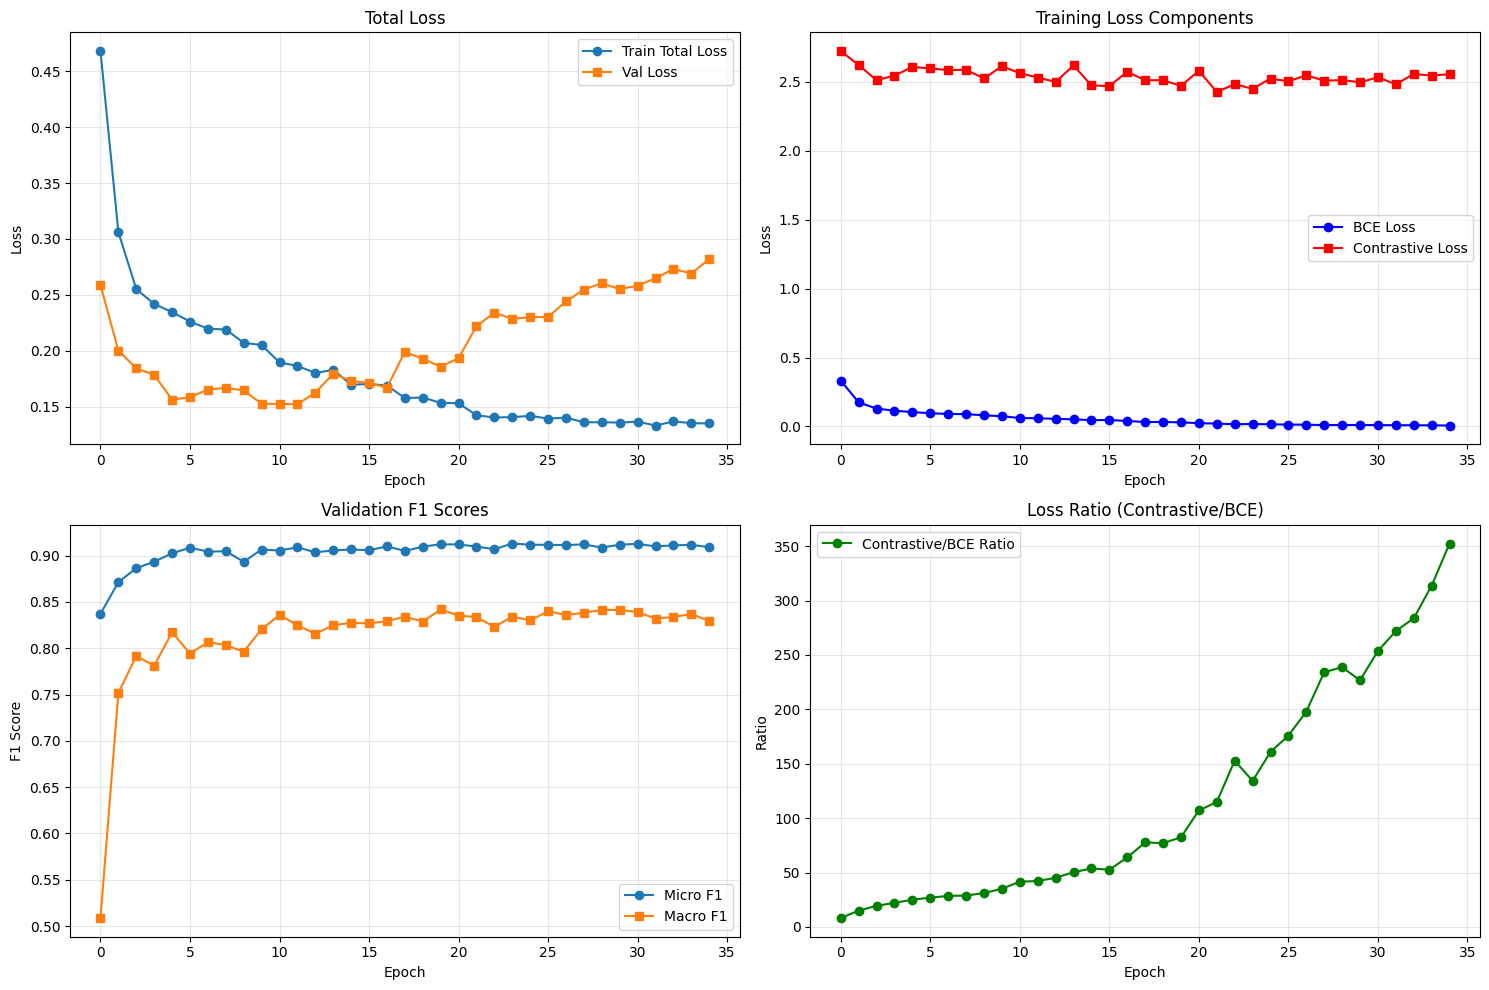

Training history visualized and saved to 'training_history_contrastive.png'


In [23]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Total Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss components
axes[0, 1].plot(history['train_loss_bce'], label='BCE Loss', marker='o', color='blue')
axes[0, 1].plot(history['train_loss_con'], label='Contrastive Loss', marker='s', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training Loss Components')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 scores
axes[1, 0].plot(history['val_micro_f1'], label='Micro F1', marker='o')
axes[1, 0].plot(history['val_macro_f1'], label='Macro F1', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Scores')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Loss ratio
loss_ratio = np.array(history['train_loss_con']) / (np.array(history['train_loss_bce']) + 1e-8)
axes[1, 1].plot(loss_ratio, label='Contrastive/BCE Ratio', marker='o', color='green')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].set_title('Loss Ratio (Contrastive/BCE)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_contrastive.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history visualized and saved to 'training_history_contrastive.png'")

## 9. Test Set Evaluation

In [28]:
# Load best model
print("Loading best model for testing...")
checkpoint = torch.load(best_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model from epoch {checkpoint['epoch']+1} loaded.\n")

# Evaluate on test set
test_loss, test_preds, test_labels, test_probs = evaluate(
    model, test_loader, criterion_bce, device, threshold=0.5
)

# Calculate metrics
test_metrics = calculate_metrics(test_labels, test_preds, class_names)

# Print results
print_metrics(test_metrics)

Loading best model for testing...
Best model from epoch 20 loaded.



Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

EVALUATION METRICS

Overall Performance:
  Micro F1:      0.9110
  Macro F1:      0.8425
  Weighted F1:   0.9112

  Micro Precision: 0.9037
  Macro Precision: 0.8536

  Micro Recall:    0.9183
  Macro Recall:    0.8381

  Hamming Loss:    0.0568
  Subset Accuracy: 0.4422



## 10. Per-Class Performance Analysis

In [29]:
# Detailed per-class results table
print("\nDetailed Per-Class Results:")
print("="*80)
print(f"{'Class':<20} {'Precision':>12} {'Recall':>12} {'F1 Score':>12} {'Support':>10}")
print("="*80)

for i, class_name in enumerate(class_names):
    support = int(test_labels[:, i].sum())
    print(f"{class_name:<20} {test_metrics['per_class_precision'][i]:>12.4f} "
          f"{test_metrics['per_class_recall'][i]:>12.4f} "
          f"{test_metrics['per_class_f1'][i]:>12.4f} {support:>10}")

print("="*80)

# Identify best and worst performing classes
best_idx = np.argmax(test_metrics['per_class_f1'])
worst_idx = np.argmin(test_metrics['per_class_f1'])

print(f"\nBest performing class: {class_names[best_idx]} (F1: {test_metrics['per_class_f1'][best_idx]:.4f})")
print(f"Worst performing class: {class_names[worst_idx]} (F1: {test_metrics['per_class_f1'][worst_idx]:.4f})")


Detailed Per-Class Results:
Class                   Precision       Recall     F1 Score    Support
airplane                   0.9091       0.9091       0.9091         11
bare soil                  0.7895       0.8904       0.8369        219
buildings                  0.9356       0.9776       0.9561        312
cars                       0.9375       0.9375       0.9375        304
chaparral                  0.3043       0.5000       0.3784         14
court                      0.7333       0.5593       0.6346         59
dock                       0.8421       0.8000       0.8205         40
field                      0.9231       0.7742       0.8421         31
grass                      0.9246       0.9707       0.9471        341
pavement                   0.9710       0.9626       0.9668        348
sand                       0.9722       0.8974       0.9333         39
sea                        0.9286       0.8125       0.8667         32
ship                       0.7500       0.7500  

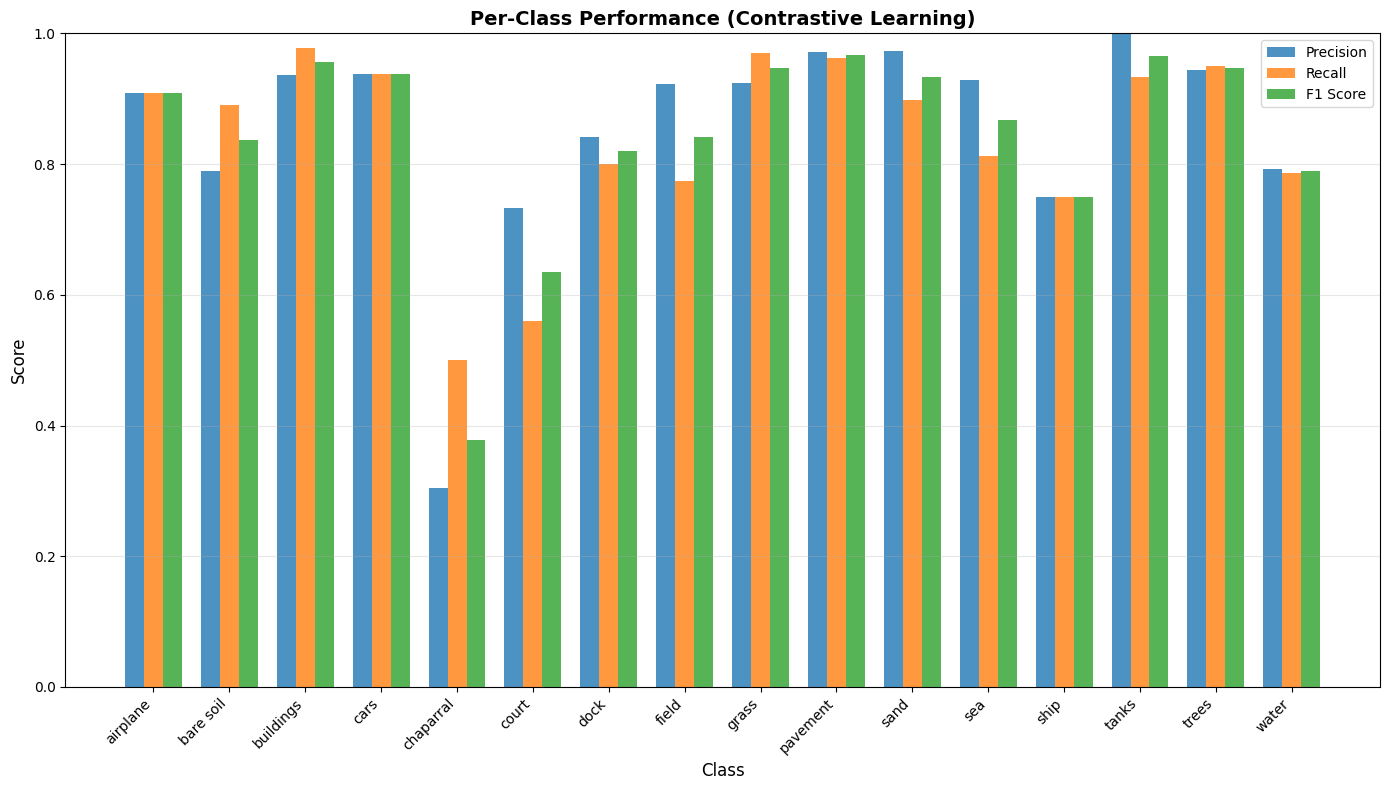

Per-class performance visualized and saved.


In [30]:
# Per-class performance visualization
per_class_data = {
    'Class': class_names,
    'F1': test_metrics['per_class_f1'],
    'Precision': test_metrics['per_class_precision'],
    'Recall': test_metrics['per_class_recall']
}

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, per_class_data['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, per_class_data['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, per_class_data['F1'], width, label='F1 Score', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance (Contrastive Learning)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('per_class_performance_contrastive.png', dpi=150, bbox_inches='tight')
plt.show()

print("Per-class performance visualized and saved.")

## 11. Comparison with Baseline

In [31]:
# Baseline results (from Approach 1)
baseline_results = {
    'Macro F1': 0.8097,
    'Micro F1': 0.9165,
    'Macro Precision': 0.8108,
    'Micro Precision': 0.9039,
    'Macro Recall': 0.8114,
    'Micro Recall': 0.9293,
    'Hamming Loss': 0.0505,
    'Subset Accuracy': 0.4667
}

# Contrastive results
contrastive_results = {
    'Macro F1': test_metrics['macro_f1'],
    'Micro F1': test_metrics['micro_f1'],
    'Macro Precision': test_metrics['macro_precision'],
    'Micro Precision': test_metrics['micro_precision'],
    'Macro Recall': test_metrics['macro_recall'],
    'Micro Recall': test_metrics['micro_recall'],
    'Hamming Loss': test_metrics['hamming_loss'],
    'Subset Accuracy': test_metrics['subset_accuracy']
}

# Comparison table
print("\n" + "="*80)
print("COMPARISON: Baseline vs Contrastive Learning")
print("="*80)
print(f"{'Metric':<25} {'Baseline':>20} {'Contrastive':>20} {'Δ Improvement':>15}")
print("="*80)

for metric in baseline_results.keys():
    baseline_val = baseline_results[metric]
    contrastive_val = contrastive_results[metric]

    # For Hamming Loss, lower is better, so invert the improvement
    if metric == 'Hamming Loss':
        improvement = baseline_val - contrastive_val
        improvement_str = f"{improvement:+.4f}"
    else:
        improvement = contrastive_val - baseline_val
        improvement_str = f"{improvement:+.4f}"

    print(f"{metric:<25} {baseline_val:>20.4f} {contrastive_val:>20.4f} {improvement_str:>15}")

print("="*80)

# Summary
macro_f1_improvement = (contrastive_results['Macro F1'] - baseline_results['Macro F1']) / baseline_results['Macro F1'] * 100
print(f"\nKey Findings:")
print(f"  Macro F1 improvement: {macro_f1_improvement:+.2f}%")
if contrastive_results['Macro F1'] > baseline_results['Macro F1']:
    print(f"  ✓ Contrastive learning IMPROVED macro F1 (better for rare classes)")
else:
    print(f"  ✗ Contrastive learning did not improve macro F1")
print("="*80)


COMPARISON: Baseline vs Contrastive Learning
Metric                                Baseline          Contrastive   Δ Improvement
Macro F1                                0.8097               0.8425         +0.0328
Micro F1                                0.9165               0.9110         -0.0055
Macro Precision                         0.8108               0.8536         +0.0428
Micro Precision                         0.9039               0.9037         -0.0002
Macro Recall                            0.8114               0.8381         +0.0267
Micro Recall                            0.9293               0.9183         -0.0110
Hamming Loss                            0.0505               0.0568         -0.0063
Subset Accuracy                         0.4667               0.4422         -0.0245

Key Findings:
  Macro F1 improvement: +4.06%
  ✓ Contrastive learning IMPROVED macro F1 (better for rare classes)


## 12. Visualization: Feature Space Analysis

In [32]:
# Extract features for visualization (t-SNE)
from sklearn.manifold import TSNE

print("Extracting features for t-SNE visualization...")

model.eval()
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Extracting features'):
        images = images.to(device)

        # Get projected features (for contrastive learning)
        features = model(images, return_projection=True)

        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

features_array = np.vstack(features_list)
labels_array = np.vstack(labels_list)

print(f"Features shape: {features_array.shape}")
print(f"Labels shape: {labels_array.shape}")

Extracting features for t-SNE visualization...


Extracting features: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

Features shape: (450, 256)
Labels shape: (450, 16)


Running t-SNE (this may take a few minutes)...
Visualizing 403 samples from top 5 classes...


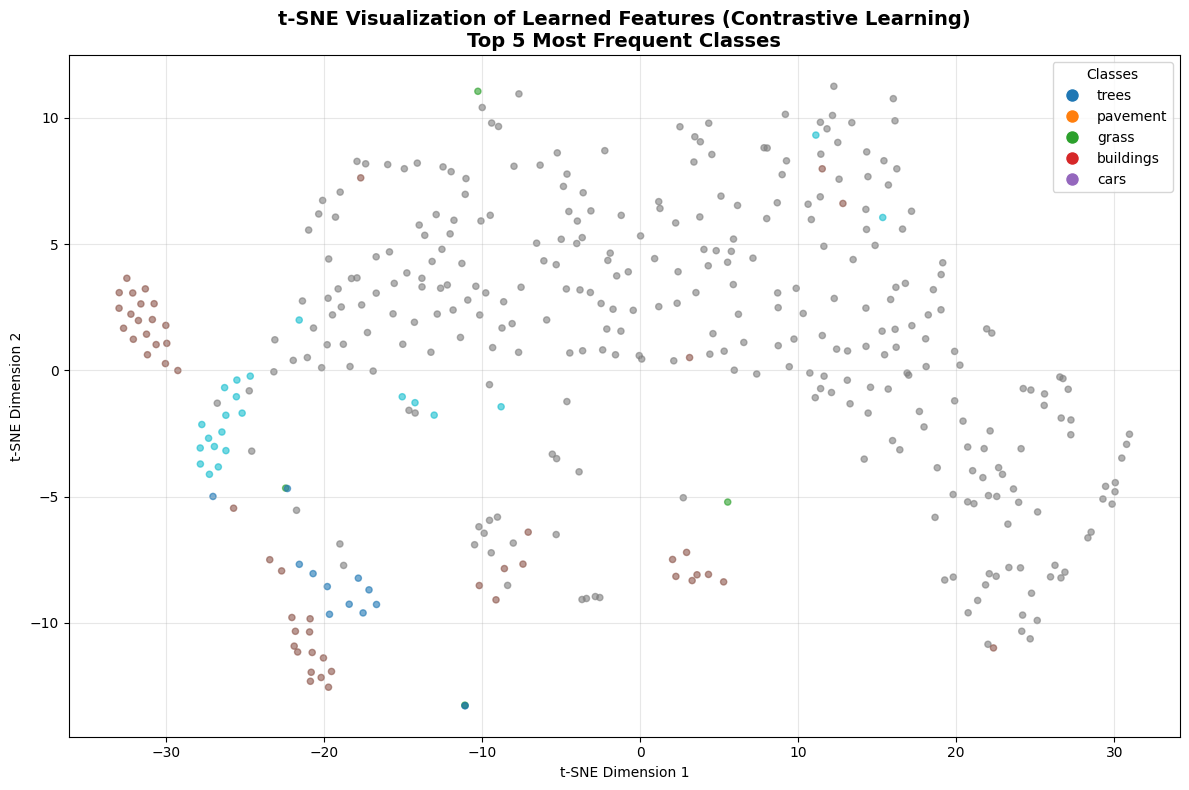

t-SNE visualization saved to 'tsne_features_contrastive.png'
Samples with shared labels should cluster together in the feature space.


In [33]:
# t-SNE visualization for top 5 most frequent classes
print("Running t-SNE (this may take a few minutes)...")

# Select top 5 most frequent classes for clearer visualization
class_counts = labels_array.sum(axis=0)
top_5_classes = np.argsort(class_counts)[-5:][::-1]

# Filter samples that have exactly one of the top 5 classes (for clearer visualization)
mask = np.zeros(len(labels_array), dtype=bool)
sample_colors = []
sample_labels = []

for i, label_vec in enumerate(labels_array):
    active_classes = np.where(label_vec == 1)[0]
    # Check if any of the active classes is in top 5
    if len(set(active_classes) & set(top_5_classes)) > 0:
        mask[i] = True
        # Use the first top-5 class as the color
        for cls in active_classes:
            if cls in top_5_classes:
                sample_colors.append(np.where(top_5_classes == cls)[0][0])
                sample_labels.append(class_names[cls])
                break

features_subset = features_array[mask]
sample_colors = np.array(sample_colors)

print(f"Visualizing {len(features_subset)} samples from top 5 classes...")

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features_subset)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                      c=sample_colors, cmap='tab10', alpha=0.6, s=20)

# Create legend
legend_labels = [class_names[i] for i in top_5_classes]
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=plt.cm.tab10(i/10), markersize=10, label=legend_labels[i])
           for i in range(5)]
plt.legend(handles=handles, title='Classes', loc='best')

plt.title('t-SNE Visualization of Learned Features (Contrastive Learning)\nTop 5 Most Frequent Classes',
          fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_features_contrastive.png', dpi=150, bbox_inches='tight')
plt.show()

print("t-SNE visualization saved to 'tsne_features_contrastive.png'")
print("Samples with shared labels should cluster together in the feature space.")

## 13. Summary and Conclusions

In [34]:
print("\n" + "="*80)
print("CONTRASTIVE LEARNING APPROACH - SUMMARY")
print("="*80)
print(f"\nModel Architecture: {MODEL_BACKBONE} with Contrastive Learning")
print(f"Contrastive Loss Weight (λ): {LAMBDA_CONTRASTIVE}")
print(f"\nTraining Configuration:")
print(f"  Epochs trained: {len(history['train_loss'])}")
print(f"  Best validation Macro F1: {best_val_f1:.4f}")
print(f"\nTest Set Performance:")
print(f"  Macro F1: {test_metrics['macro_f1']:.4f}")
print(f"  Micro F1: {test_metrics['micro_f1']:.4f}")
print(f"  Macro Precision: {test_metrics['macro_precision']:.4f}")
print(f"  Macro Recall: {test_metrics['macro_recall']:.4f}")
print(f"\nImprovement over Baseline:")
macro_improvement = test_metrics['macro_f1'] - baseline_results['Macro F1']
micro_improvement = test_metrics['micro_f1'] - baseline_results['Micro F1']
print(f"  Macro F1: {macro_improvement:+.4f} ({macro_improvement/baseline_results['Macro F1']*100:+.2f}%)")
print(f"  Micro F1: {micro_improvement:+.4f} ({micro_improvement/baseline_results['Micro F1']*100:+.2f}%)")
print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("1. Contrastive learning helps learn better feature representations")
print("2. Images with shared labels are pulled together in feature space")
print("3. Particularly beneficial for rare/minority classes")
print("4. Jaccard similarity enables soft weighting of label overlap")
print("5. Combined loss (BCE + Contrastive) balances classification and representation learning")
print("="*80)

print("\nFiles Generated:")
print("  - best_model_contrastive.pth (model checkpoint)")
print("  - training_history_contrastive.png (loss and F1 curves)")
print("  - per_class_performance_contrastive.png (per-class metrics)")
print("  - tsne_features_contrastive.png (feature space visualization)")


CONTRASTIVE LEARNING APPROACH - SUMMARY

Model Architecture: efficientnet_b4 with Contrastive Learning
Contrastive Loss Weight (λ): 0.05

Training Configuration:
  Epochs trained: 35
  Best validation Macro F1: 0.8419

Test Set Performance:
  Macro F1: 0.8425
  Micro F1: 0.9110
  Macro Precision: 0.8536
  Macro Recall: 0.8381

Improvement over Baseline:
  Macro F1: +0.0328 (+4.06%)
  Micro F1: -0.0055 (-0.61%)

KEY INSIGHTS:
1. Contrastive learning helps learn better feature representations
2. Images with shared labels are pulled together in feature space
3. Particularly beneficial for rare/minority classes
4. Jaccard similarity enables soft weighting of label overlap
5. Combined loss (BCE + Contrastive) balances classification and representation learning

Files Generated:
  - best_model_contrastive.pth (model checkpoint)
  - training_history_contrastive.png (loss and F1 curves)
  - per_class_performance_contrastive.png (per-class metrics)
  - tsne_features_contrastive.png (feature sp

## 14. Next Steps and Future Work

### Potential Improvements:
1. **Tune contrastive weight (λ)**: Try different values (0.1, 0.3, 0.7, 1.0)
2. **Temperature tuning**: Experiment with different temperatures (0.05, 0.1, 0.2)
3. **Hard negative mining**: Focus on hard negative pairs for stronger gradients
4. **Momentum encoder**: Use MoCo-style momentum encoder for more stable features
5. **Multi-positive contrastive**: Use all positive pairs, not just within-batch
6. **Combine with GCN**: Add label correlation modeling via Graph Convolutional Networks
7. **Self-supervised pre-training**: Pre-train on unlabeled aerial imagery first

### Ablation Studies:
- Binary overlap vs Jaccard similarity for label matching
- Effect of projection head dimension (128, 256, 512)
- Impact of different backbone architectures (ViT, ConvNeXt)
- Comparison of different contrastive loss variants (SimCLR, SupCon, etc.)